# EDA and Feature Engineering

In [1]:
import os, sys

import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
from data import download_stock_price_prediction_challenge_data
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)


rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


In [3]:
if LOCAL:
    dirfpath = download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices"

test_dfs = []
for i in range(1, 6):
    df = pd.read_csv(os.path.join(test_path, f"test_{i}.csv"))
    df = df.rename(columns={
        "Returns": f"return_{i}",
        "Close": f"close_{i}",
        "Volume": f"volume_{i}"
    })
    test_dfs.append(df)

merged_df = test_dfs[0][['Date', f'return_1', f'close_1', f'volume_1']]
for i in range(1, 5):
    df_i = test_dfs[i][['Date', f'return_{i+1}', f'close_{i+1}', f'volume_{i+1}']]
    merged_df = pd.merge(merged_df, df_i, on='Date', how='outer')

indices = {
    "dj": "Dow_Jones.csv",
    "nasdaq": "NASDAQ.csv",
    "SP500": "SP500.csv"
}

for key, filename in indices.items():
    index_df = pd.read_csv(os.path.join(train_indices_path, filename))
    index_df = index_df.rename(columns={"Returns": f"returns_{key}"})
    merged_df = pd.merge(merged_df, index_df[['Date', f'returns_{key}']], on='Date', how='left')

merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

print(merged_df.head())

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped
        Date  return_1    close_1  volume_1  return_2     close_2  volume_2  \
0 2015-01-05  0.014057  56.990002    593600  0.006149  137.287811   1425263   
1 2015-01-06  0.008072  57.450001    825000 -0.001919  137.024384   2370723   
2 2015-01-07  0.036902  59.570000   1053500  0.023424  140.234146   1411220   
3 2015-01-08  0.031392  61.439999   1289100  0.018228  142.790237   1374218   
4 2015-01-09  0.018555  62.580002   1549400 -0.011820  141.102432    926088   

   return_3    close_3  volume_3  return_4  close_4  volume_4  return_5  \
0 -0.021394  86.449997   3007000       NaN      NaN       NaN -0.013267   
1 -0.008329  85.730003   3512000       NaN      NaN       NaN -0.014449   
2 -0.004316  85.360001   3055900       NaN      NaN       NaN  0.012624   
3  0.013238  86.489998   2842300       NaN      NaN       NaN  0.01

In [ ]:
window = 10

for i in range(1, 6):
    merged_df[f'ma10_{i}'] = merged_df[f'close_{i}'].rolling(window=10).mean()
    merged_df[f'ma20_{i}'] = merged_df[f'close_{i}'].rolling(window=20).mean()
    
    merged_df[f'envelope_upper_{i}'] = merged_df[f'ma10_{i}'] * 1.05
    merged_df[f'envelope_lower_{i}'] = merged_df[f'ma10_{i}'] * 0.95

    merged_df[f'roc10_{i}'] = merged_df[f'close_{i}'].pct_change(periods=10)

    # rolling correlations with indices
    for index_key in ['dj', 'nasdaq', 'SP500']:
        returns_index_col = f'returns_{index_key}'
        
        rolling_cov = merged_df[[f'return_{i}', returns_index_col]].rolling(window=window).cov()
        
        cov = rolling_cov.loc[
            rolling_cov.index.get_level_values(1) == returns_index_col,
            f'return_{i}'
        ].reset_index(drop=True)

        var = merged_df[returns_index_col].rolling(window=window).var()
        
        merged_df[f'beta_{i}_{index_key}'] = cov / var
merged_df.head()

,Date,return_1,close_1,volume_1,return_2,close_2,volume_2,return_3,close_3,volume_3,...,beta_4_nasdaq,beta_4_SP500,ma10_5,ma20_5,envelope_upper_5,envelope_lower_5,roc10_5,beta_5_dj,beta_5_nasdaq,beta_5_SP500
0,2015-01-05,0.014057,56.990002,593600,0.006149,137.287811,1425263,-0.021394,86.449997,3007000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-06,0.008072,57.450001,825000,-0.001919,137.024384,2370723,-0.008329,85.730003,3512000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-07,0.036902,59.570000,1053500,0.023424,140.234146,1411220,-0.004316,85.360001,3055900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-08,0.031392,61.439999,1289100,0.018228,142.790237,1374218,0.013238,86.489998,2842300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-09,0.018555,62.580002,1549400,-0.011820,141.102432,926088,-0.009712,85.650002,2325300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


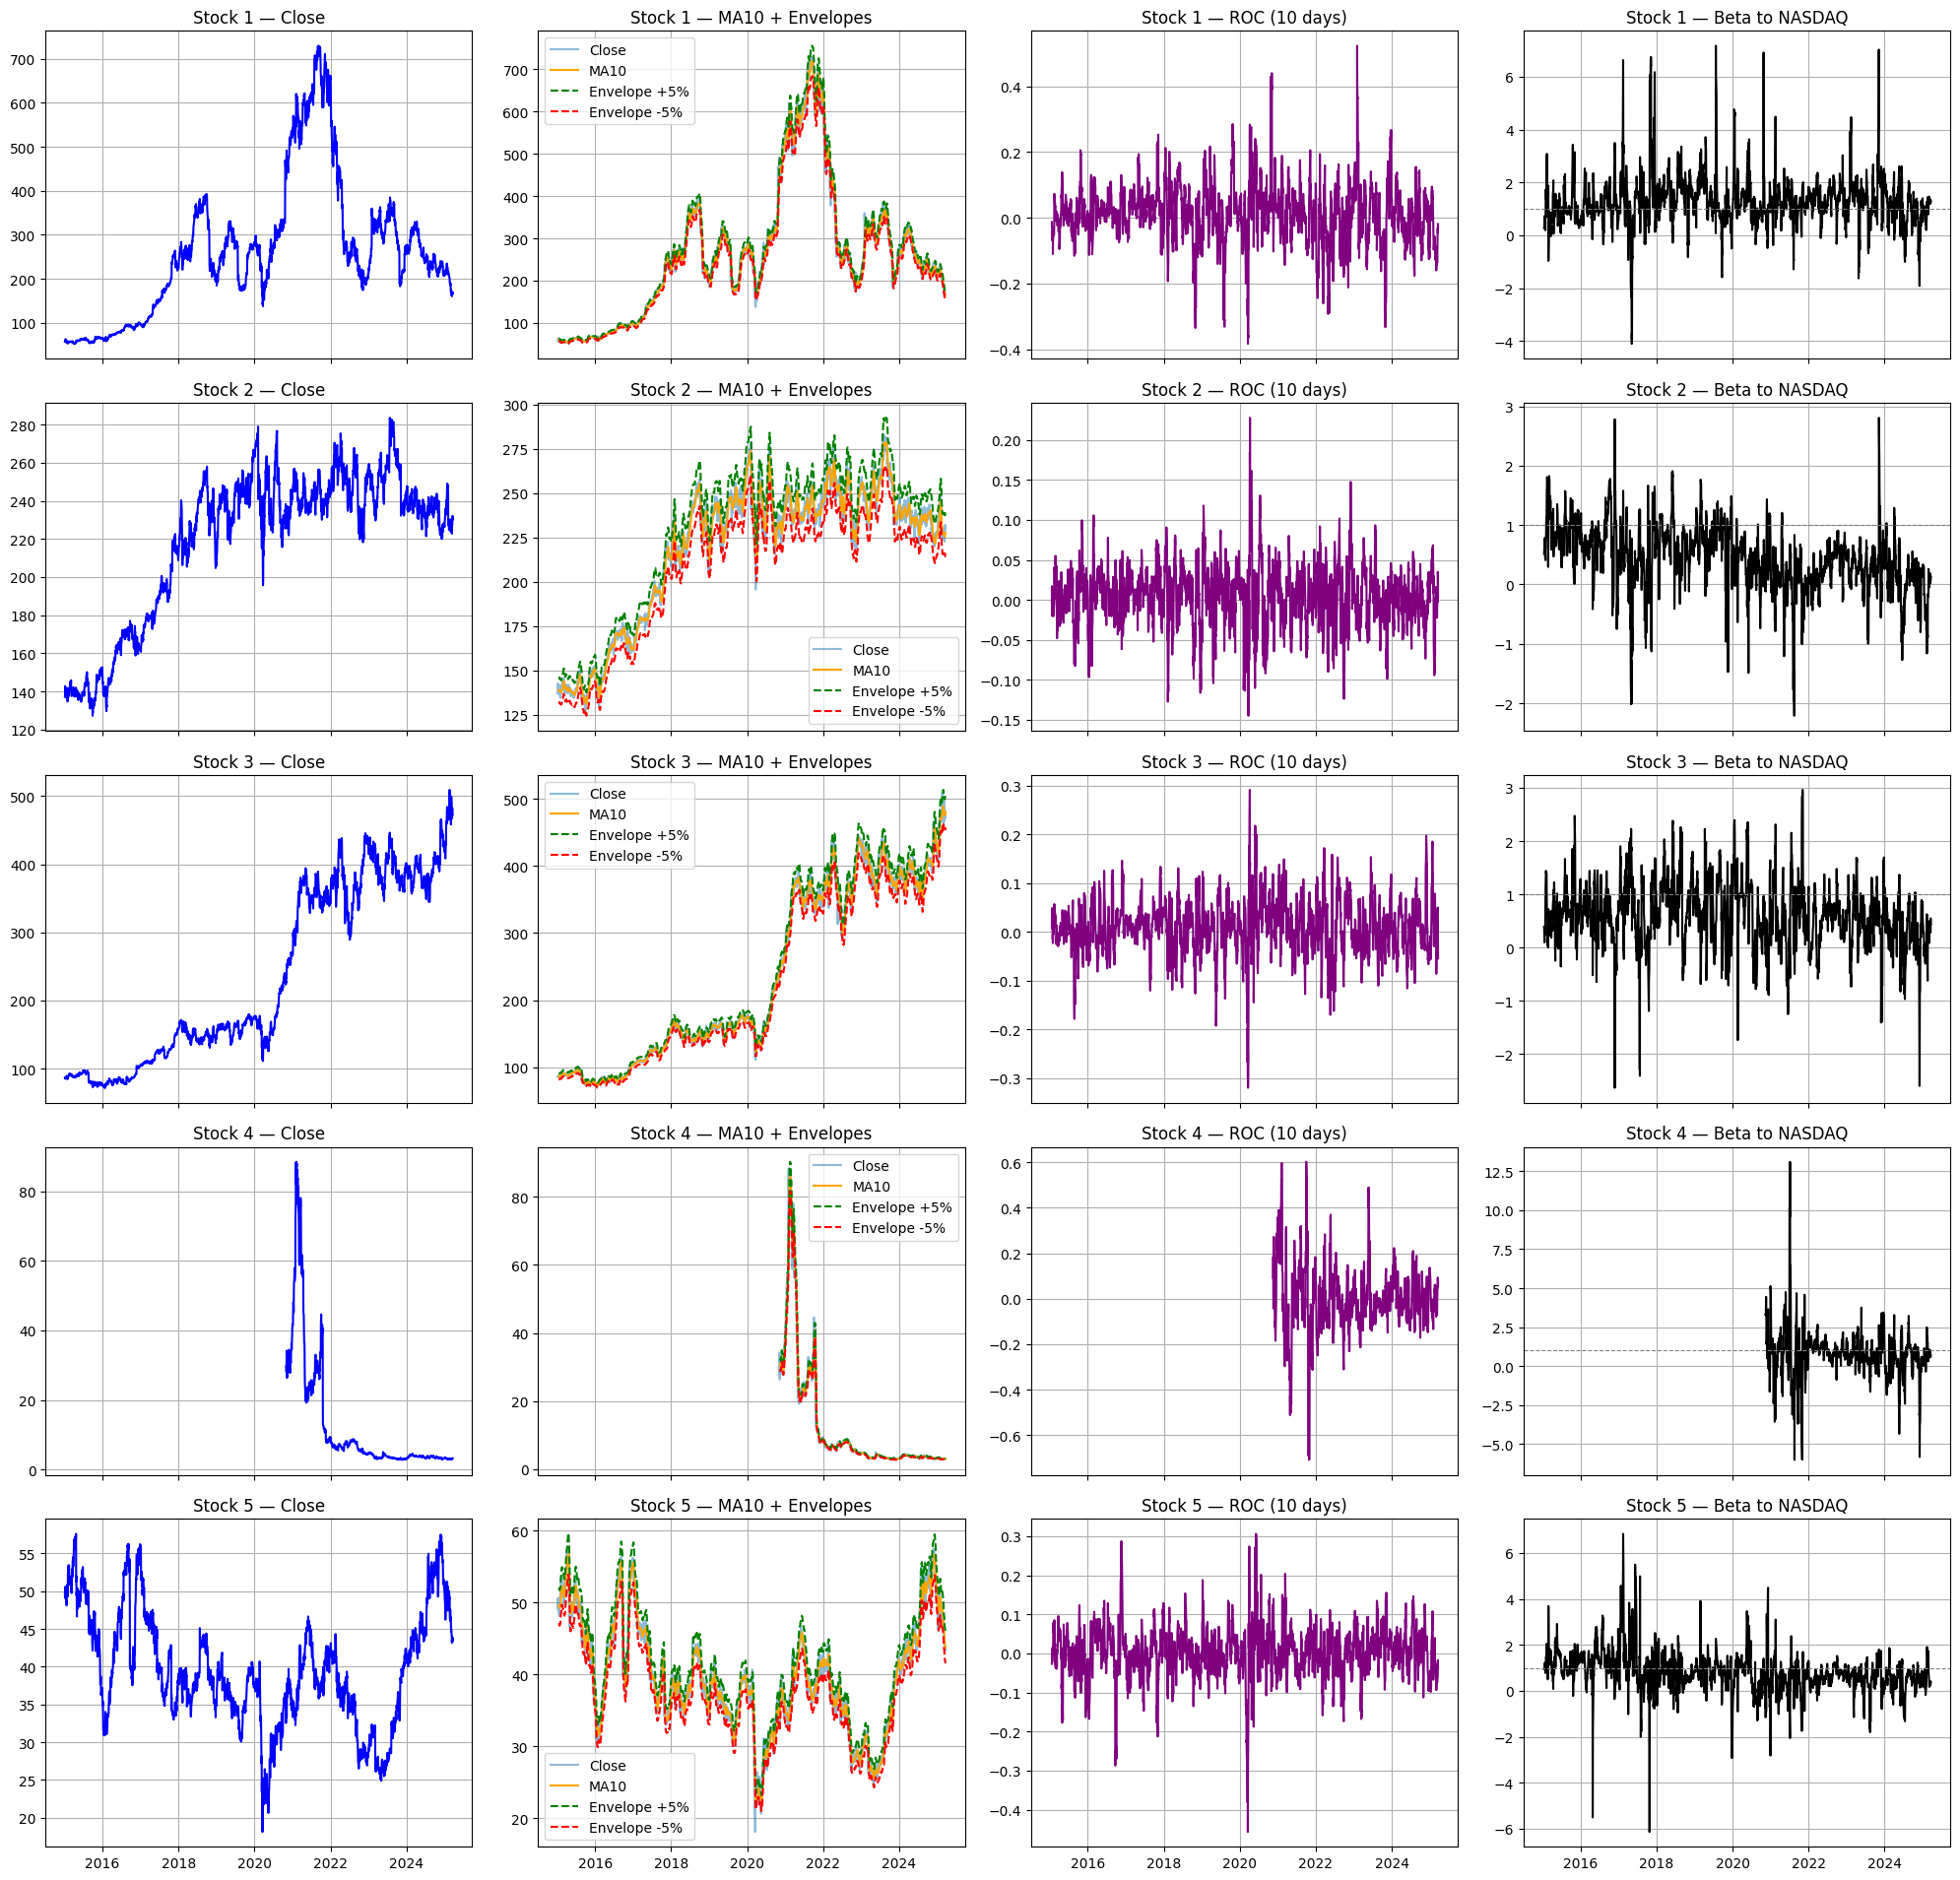

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True)

for i in range(1, 6):
    axes[i-1, 0].plot(merged_df['Date'], merged_df[f'close_{i}'], label='Close', color='blue')
    axes[i-1, 0].set_title(f'Stock {i} — Close')
    axes[i-1, 0].grid()

    axes[i-1, 1].plot(merged_df['Date'], merged_df[f'close_{i}'], label='Close', alpha=0.5)
    axes[i-1, 1].plot(merged_df['Date'], merged_df[f'ma10_{i}'], label='MA10', color='orange')
    axes[i-1, 1].plot(merged_df['Date'], merged_df[f'envelope_upper_{i}'], '--', color='green', label='Envelope +5%')
    axes[i-1, 1].plot(merged_df['Date'], merged_df[f'envelope_lower_{i}'], '--', color='red', label='Envelope -5%')
    axes[i-1, 1].set_title(f'Stock {i} — MA10 + Envelopes')
    axes[i-1, 1].legend()
    axes[i-1, 1].grid()

    axes[i-1, 2].plot(merged_df['Date'], merged_df[f'roc10_{i}'], label='ROC10', color='purple')
    axes[i-1, 2].set_title(f'Stock {i} — ROC (10 days)')
    axes[i-1, 2].grid()

    axes[i-1, 3].plot(merged_df['Date'], merged_df[f'beta_{i}_nasdaq'], label='Beta', color='black')
    axes[i-1, 3].set_title(f'Stock {i} — Beta to NASDAQ')
    axes[i-1, 3].axhline(1, color='gray', linestyle='--', linewidth=0.8)
    axes[i-1, 3].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

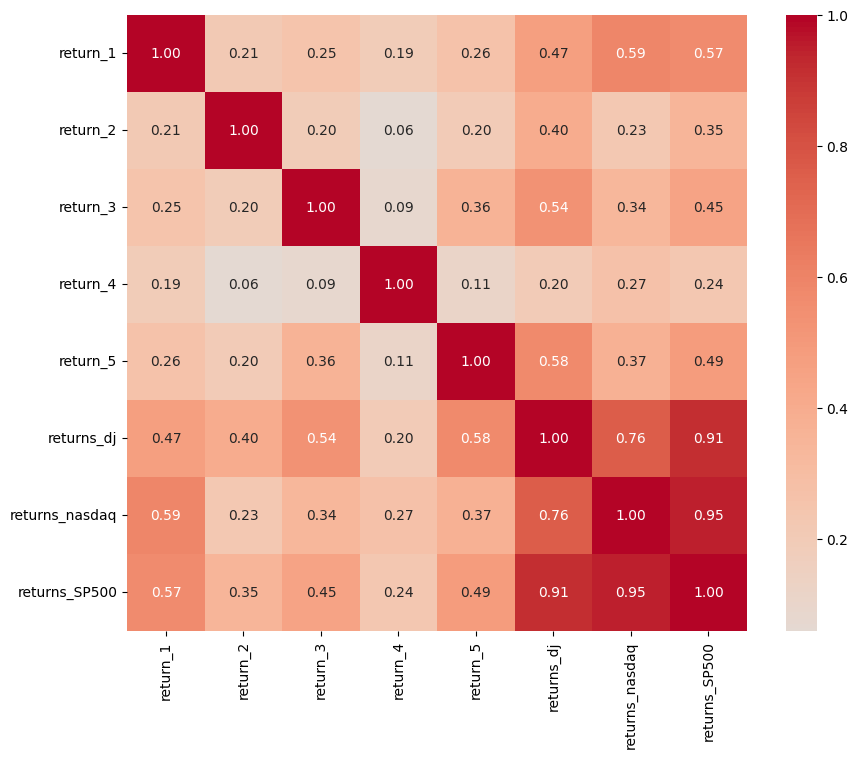

In [19]:
corr_columns = [f'return_{i}' for i in range(1, 6)] + ['returns_dj', 'returns_nasdaq', 'returns_SP500']

corr_df = merged_df[corr_columns].dropna()

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.show()

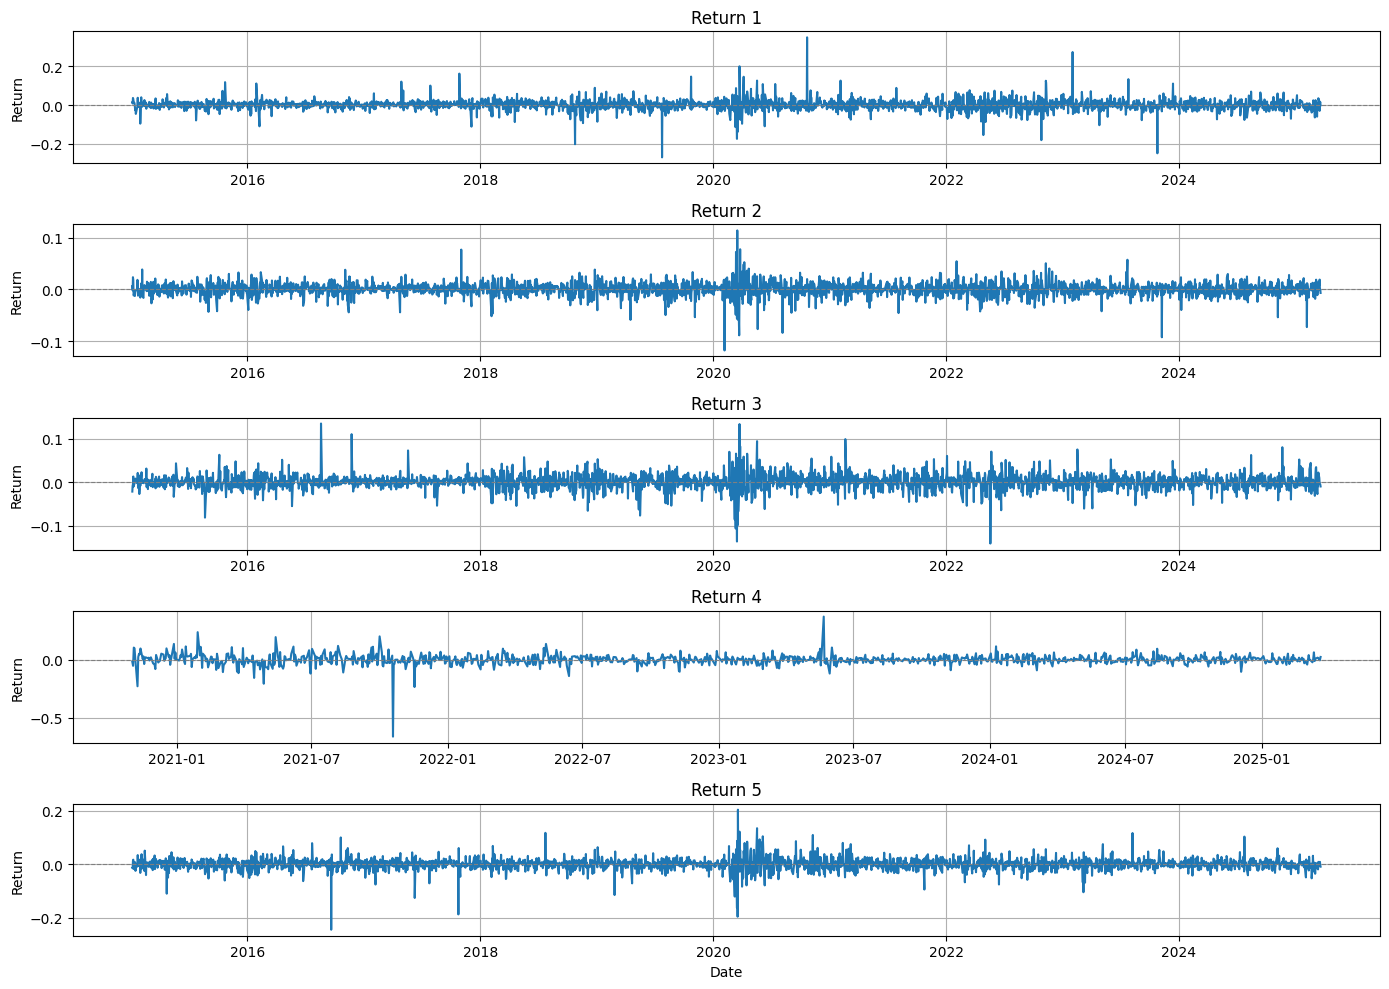

In [20]:
plt.figure(figsize=(14, 10))

for i in range(1, 6):
    plt.subplot(5, 1, i)
    plt.plot(merged_df['Date'], merged_df[f'return_{i}'], label=f'Return {i}', color='tab:blue')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.ylabel('Return')
    plt.title(f'Return {i}')
    plt.grid(True)
    if i == 5:
        plt.xlabel('Date')

plt.tight_layout()
plt.show()


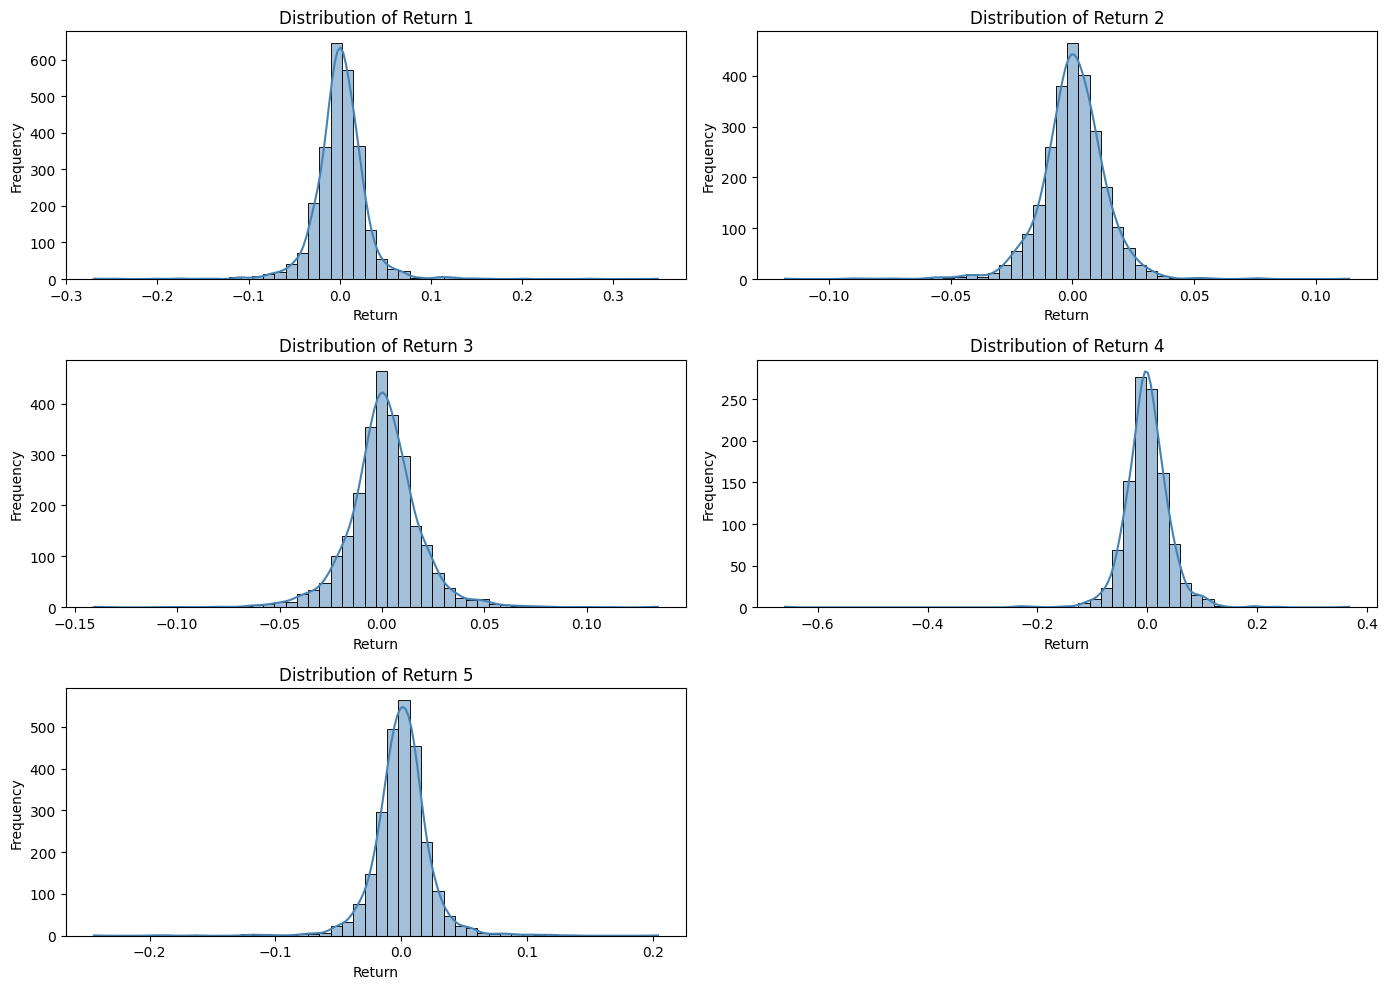

In [21]:
plt.figure(figsize=(14, 10))

for i in range(1, 6):
    plt.subplot(3, 2, i)
    sns.histplot(merged_df[f'return_{i}'].dropna(), kde=True, bins=50, color='steelblue')
    plt.title(f'Distribution of Return {i}')
    plt.xlabel('Return')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()